In [12]:
import math
import warnings
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns
sns.set(font='IPAexGothic')

In [2]:
warnings.filterwarnings("ignore")

In [3]:
# 企業名 → TSEティッカー
TICKERS = {
    "三菱ケミカルグループ": "4188.T",   # Mitsubishi Chemical Group
    "住友化学":           "4005.T",
    "三井化学":           "4183.T",
    "信越化学工業":       "4063.T",
    "旭化成":             "3407.T",
    "積水化学工業":       "4204.T",
    "日産化学":           "4021.T",
    "東ソー":             "4042.T",
    "日東電工":           "6988.T",
    "日本酸素HD":         "4091.T",   # Nippon Sanso Holdings
}

In [4]:
# 安全に値を取り出すヘルパ
def safe_get(d, key, default=None):
    try:
        v = d.get(key, default)
        return float(v) if v is not None else default
    except Exception:
        return default

In [17]:
def _find_row_relaxed(df, candidates):
    # 行名ゆれに強い検索（完全一致→小文字化して一致）
    for c in candidates:
        if c in df.index:
            return df.loc[c]
    lower = {i.lower(): i for i in df.index}
    for c in candidates:
        key = c.lower()
        if key in lower:
            return df.loc[lower[key]]
    return None

def _safe_float(x):
    try:
        return float(x)
    except Exception:
        return None

def compute_roe_from_statements(balance_sheet, income_stmt):
    """
    ROE(%) = NetIncome / Avg(Equity) * 100
    - balance_sheet, income_stmt は yfinance の DataFrame（列=期, col[0]が直近期）
    - 直近2期の平均自己資本を使用（1期しか無い場合はその期）
    """
    if balance_sheet is None or balance_sheet.empty or income_stmt is None or income_stmt.empty:
        return None

    # 純利益の候補（銘柄やIFRS/US-GAAPで名称が揺れる）
    ni_candidates = [
        "Net Income",
        "Net Income Common Stockholders",
        "Net Income Applicable To Common Shares",
        "Net Income From Continuing Operations",
        "Net Income Including Noncontrolling Interests",
    ]
    ni_row = _find_row_relaxed(income_stmt, ni_candidates)
    net_income = None
    if ni_row is not None and not ni_row.empty:
        net_income = _safe_float(ni_row.iloc[0])

    # 自己資本の候補（少なくともどれかは入っている想定）
    equity_candidates = [
        "Total Stockholder Equity",
        "Total Shareholder Equity",
        "Stockholders Equity",
        "Total Equity Gross Minority Interest",  # IFRSだとこれしか無いケースあり（非支配含む）
    ]
    eq_row = _find_row_relaxed(balance_sheet, equity_candidates)

    # 直近と前期の自己資本を取得して平均化
    avg_equity = None
    if eq_row is not None and not eq_row.empty:
        eq_latest = _safe_float(eq_row.iloc[0])
        eq_prev = _safe_float(eq_row.iloc[1]) if eq_row.size >= 2 else None
        if eq_latest is not None and eq_prev is not None:
            avg_equity = (eq_latest + eq_prev) / 2.0
        else:
            avg_equity = eq_latest

    if net_income is None or avg_equity is None or avg_equity == 0:
        return None

    return (net_income / avg_equity) * 100.0


In [18]:
def fetch_metrics(tk):
    """
    Yahoo Financeから指標を収集して dict を返す
    - PER: info["trailingPE"]
    - PBR: info["priceToBook"]
    - ROE: info["returnOnEquity"] (単位: 小数→%換算)
    - 自己資本比率: Total Equity / Total Assets（直近期, %）
    - ROIC(近似): NOPAT / Invested Capital
        NOPAT ≈ EBIT * (1 - 税率)
        Invested Capital ≈ Total Debt + Total Equity - Cash
    """
    t = yf.Ticker(tk)

    info = t.info or {}
    # 財務諸表（最新列を使う）
    bs   = t.balance_sheet   # 資産負債（列=期, col[0]が直近期）
    fin  = t.financials      # P/L
    cf   = t.cashflow

    # --- 市場系 ---
    per = safe_get(info, "trailingPE")
    pbr = safe_get(info, "priceToBook")

    # --- ROE ---
    # 1) まずは info から（あればそれを使う）
    roe_raw = safe_get(info, "returnOnEquity")  # 小数
    if roe_raw is not None:
        roe = roe_raw * 100
    else:
        # 2) 無ければ財務諸表から算出
        roe = compute_roe_from_statements(bs, fin)

    # --- 自己資本比率 ---
    total_assets = None
    total_equity = None
    if bs is not None and not bs.empty:
        # 行名は英名/大小ゆれがあるので候補を網羅
        def find_row(df, candidates):
            for c in candidates:
                if c in df.index:
                    return df.loc[c]
            # ゆるく小文字比較
            lower = {i.lower(): i for i in df.index}
            for c in candidates:
                if c.lower() in lower:
                    return df.loc[lower[c.lower()]]
            return None

        assets_row = find_row(bs, ["Total Assets"])
        equity_row = find_row(bs, ["Total Stockholder Equity", "Total Shareholder Equity", "Stockholders Equity"])

        if assets_row is not None and not assets_row.empty:
            total_assets = float(assets_row.iloc[0])
        if equity_row is not None and not equity_row.empty:
            total_equity = float(equity_row.iloc[0])

    equity_ratio = None
    if total_assets and total_equity and total_assets != 0:
        equity_ratio = (total_equity / total_assets) * 100.0

    # --- ROIC(近似) ---
    # NOPAT ≈ EBIT * (1 - tax rate)
    ebit = None
    tax_rate = safe_get(info, "effectiveTaxRate")  # 取得できれば使う
    if fin is not None and not fin.empty:
        # 行名ゆれ対策
        candidates_ebit = ["Ebit", "EBIT", "Earnings Before Interest and Taxes"]
        for c in candidates_ebit:
            if c in fin.index and not fin.loc[c].empty:
                ebit = float(fin.loc[c].iloc[0])
                break

    # 税率が取れない場合のフォールバック（便宜的に30%）
    if tax_rate is None:
        tax_rate = 0.30
    nopat = None
    if ebit is not None:
        nopat = ebit * (1 - tax_rate)

    # Invested Capital ≈ Total Debt + Total Equity - Cash
    total_debt = None
    cash = None
    if bs is not None and not bs.empty:
        candidates_debt = ["Total Debt"]
        for c in candidates_debt:
            if c in bs.index and not bs.loc[c].empty:
                total_debt = float(bs.loc[c].iloc[0])
                break
        # 候補を増やす（Long/Shortの合算）
        if total_debt is None:
            long_debt = bs.loc["Long Term Debt"].iloc[0] if "Long Term Debt" in bs.index else 0.0
            short_debt = bs.loc["Short Long Term Debt"].iloc[0] if "Short Long Term Debt" in bs.index else 0.0
            try:
                total_debt = float(long_debt) + float(short_debt)
            except Exception:
                total_debt = None

        # 現金同等物
        candidates_cash = ["Cash And Cash Equivalents", "Cash And Cash Equivalents And Short Term Investments", "Cash"]
        for c in candidates_cash:
            if c in bs.index and not bs.loc[c].empty:
                cash = float(bs.loc[c].iloc[0])
                break

    invested_capital = None
    if total_equity is not None and total_debt is not None:
        invested_capital = total_debt + total_equity - (cash or 0.0)

    roic = None
    if nopat is not None and invested_capital and invested_capital != 0:
        roic = (nopat / invested_capital) * 100.0  # %

    return {
        "PER": per,
        "PBR": pbr,
        "ROE(%)": roe,
        "自己資本比率(%)": equity_ratio,
        "ROIC(%)_approx": roic,
    }

In [19]:
# 収集
rows = []
for name, tk in TICKERS.items():
    try:
        m = fetch_metrics(tk)
    except Exception as e:
        m = {"PER": None, "PBR": None, "ROE(%)": None, "自己資本比率(%)": None, "ROIC(%)_approx": None}
    m["会社"] = name
    m["Ticker"] = tk
    rows.append(m)

In [20]:
df = pd.DataFrame(rows).set_index("会社")
cols = ["Ticker", "ROIC(%)_approx", "PER", "PBR", "ROE(%)", "自己資本比率(%)"]
df = df[cols]

In [21]:
# 表示 & 保存
pd.set_option("display.float_format", lambda x: f"{x:,.2f}")
#print(df)
#df.to_csv("chem_10_metrics_latest.csv", encoding="utf-8-sig")

In [22]:
df

,Ticker,ROIC(%)_approx,PER,PBR,ROE(%),自己資本比率(%)
会社,,,,,,
三菱ケミカルグループ,4188.T,4.17,25.84,0.66,4.11,29.53
住友化学,4005.T,7.46,19.30,0.84,1.11,26.19
三井化学,4183.T,4.27,21.37,0.82,2.86,39.38
信越化学工業,4063.T,17.49,18.18,2.21,12.52,82.72
旭化成,3407.T,5.36,12.19,0.89,7.35,46.31
積水化学工業,4204.T,10.92,13.89,1.41,10.24,60.67
日産化学,4021.T,17.09,16.56,3.03,19.66,70.53
東ソー,4042.T,8.43,12.20,0.87,7.15,62.32
日東電工,6988.T,19.37,18.66,2.44,13.53,78.98


In [45]:
# ---- 固定レンジ定義（min, max, invert_flag）----
# invert=True は「低いほど望ましい」指標（PER/PBR）を外側に出すため反転
METRIC_BOUNDS = {
    "自己資本比率(%)":   (0.0, 100.0, False),
    "ROE(%)":           (0.0,  20.0,  False),  # 20%以上は20%にプロット
    "PER":              (10.0,  25.0,  True),   # 25倍以上は25倍
    "PBR":              (0.5,   3.0,  True),   # 3倍以上は3倍
    "ROIC(%)_approx":   (0.0,  15.0,  False),  # 15%以上は15%
}

In [46]:
def _clamp(v, lo, hi):
    if v is None or (isinstance(v, float) and np.isnan(v)):
        return np.nan
    return max(lo, min(hi, float(v)))

def _norm(v, lo, hi):
    if np.isnan(v):
        return np.nan
    return (v - lo) / (hi - lo) if hi > lo else 0.0

In [100]:
def radar_plot_fixed(df_metrics, title="化学各社：固定レンジ・レーダー"):
    """df_metrics: 行=企業, 列= ['ROIC(%)_approx','ROE(%)','自己資本比率(%)','PER','PBR'] を想定
       - 各指標を固定レンジでクリップ（上限超→上限、0未満→0）
       - PER/PBRは反転（低いほど外側）
       - 欠損は 0 に置換して描画（必要ならコメントアウトしてnp.nanのままに）
    """
    metrics = ["ROIC(%)_approx", "ROE(%)", "自己資本比率(%)", "PER", "PBR"]  # 並びは任意でOK
    data = df_metrics[metrics].copy()

    # クリップ & 正規化（固定レンジ）
    normed = pd.DataFrame(index=data.index, columns=metrics, dtype=float)
    for m in metrics:
        lo, hi, invert = METRIC_BOUNDS[m]
        clamped = data[m].apply(lambda x: _clamp(x, lo, hi))
        scaled  = clamped.apply(lambda x: _norm(x, lo, hi))
        if invert:
            scaled = 1.0 - scaled
        # 欠損は 0（中心）に置換して描画の破綻を防ぐ
        normed[m] = scaled.fillna(0.0)

    # レーダー座標準備
    labels = metrics
    N = len(labels)
    angles = np.linspace(0, 2*np.pi, N, endpoint=False).tolist()
    angles += angles[:1]

    fig = plt.figure(figsize=(9, 9))
    ax = plt.subplot(111, polar=True)

    # 10社すべて別色の実線
    colors = plt.cm.get_cmap("tab10", len(normed.index))

    for i, comp in enumerate(normed.index):
        vals = normed.loc[comp, labels].tolist()
        vals += vals[:1]
        ax.plot(angles, vals, linewidth=2, linestyle='-', color=colors(i), label=comp)
        ax.fill(angles, vals, alpha=0.05, color=colors(i))

    # 軸と固定レンジの注記
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

     # 軸ラベルを少し外側にずらす
    label_distance = 1.15  # 通常より外側に
    for angle, label in zip(angles[:-1], labels):
        ha = "center"
        va = "center"
        x, y = np.cos(angle) * label_distance, np.sin(angle) * label_distance
        # 下側に来るラベルはさらに少し下へ
        if y < 0:
            y -= 0.05
            va = "top"
        ax.text(angle, label_distance, label, ha=ha, va=va, fontsize=11, weight='bold')

    # --- 固定レンジ一覧（右下に追加） ---
    bounds_text = "指標レンジ\n"
    for k, (lo, hi, inv) in METRIC_BOUNDS.items():
        arrow = "下限" if inv else "上限"
        bounds_text += f"・{k}: {lo:g}～{hi:g}（{arrow}）\n"

    plt.text(0.95, 0.20, bounds_text,
             transform=ax.transAxes,
             fontsize=9,
             va='top', ha='left',
             bbox=dict(facecolor='white', alpha=0.6, edgecolor='gray', boxstyle='round,pad=0.3'))

    ax.grid(True, linestyle='--', linewidth=0.8)
    ax.set_title(title, fontsize=14, pad=20, weight='bold')
    plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1.0), fontsize=9, title="企業名", title_fontsize=10, frameon=False)
    plt.tight_layout()
    plt.show()

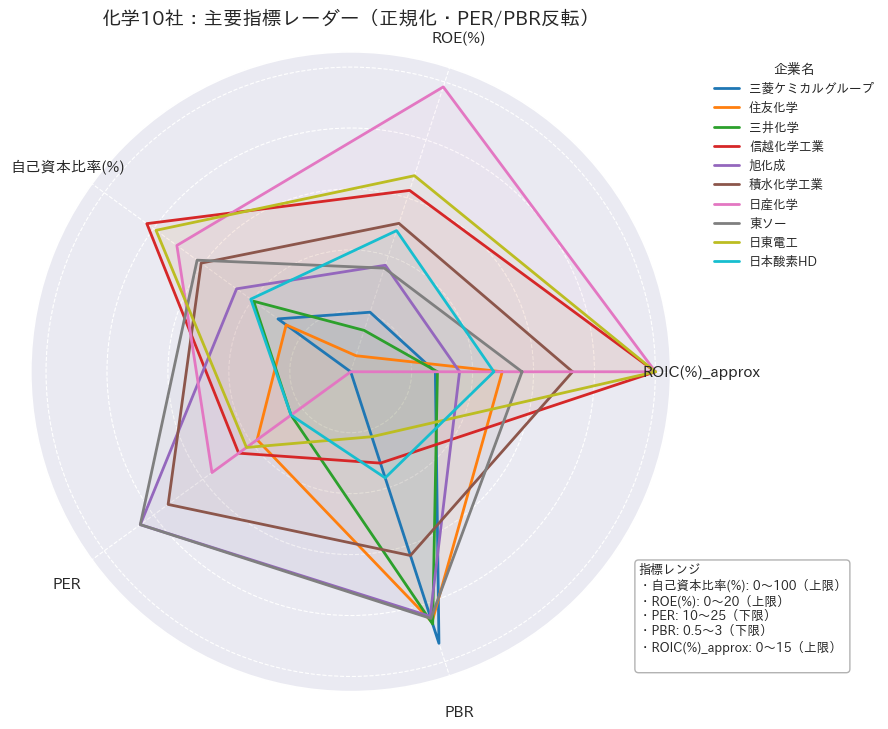

In [101]:
# 全社レーダー（煩雑なら下の上位5社版を使ってください）
radar_plot_fixed(df.drop(columns=["Ticker"]), title="化学10社：主要指標レーダー（正規化・PER/PBR反転）")

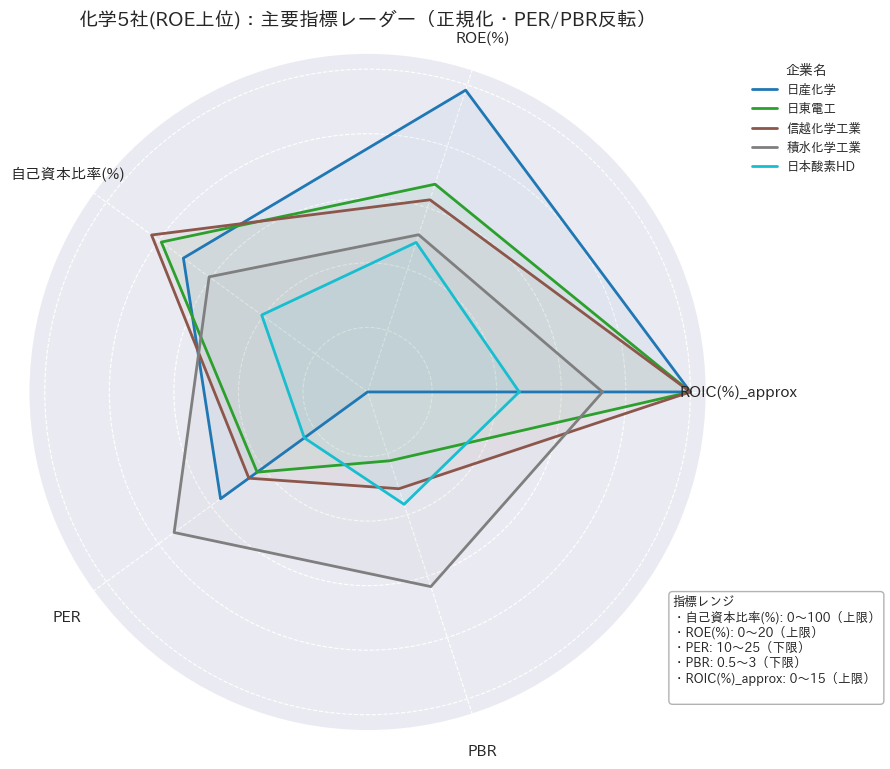

In [102]:
# 例：ROIC 上位5社のみでレーダー
top5 = df.sort_values("ROE(%)", ascending=False).head(5)
radar_plot_fixed(top5.drop(columns=["Ticker"]), title="化学5社(ROE上位)：主要指標レーダー（正規化・PER/PBR反転）")